<h1><a style="float: left;" target="_blank" href="https://www.couchbase.com/"><img style="height: 40px; margin-right: 20px;" src="https://softwarereviews.s3.amazonaws.com/production/favicons/offerings/4476/original/Couchbase-logo.png" /></a><span style="display: inline-block;">Predictive Maintenance</span></h1>
<div style="padding-bottom: 20px;"><b>January 2024</b></div>
<h2>Scenario</h2>
<div style="display: flex;">
    <div style="flex: 50%; text-align: center;">
        <img src="images/predictive-maintenance.png">
    </div>
    <div style="flex: 50%; padding-right: 100px;">

#### You are a Data Scientist!

You work for a manuafacturing company that has been implementing a Preventative and Predictive Maintenance (PPM) program for the past year. They have finished the preventititve portion and the machines have been instrumeneted and monitored by a factory floor application for each process. You have been asked to create a Predictive Maintenance model for one of their product lines. The factory floor application records all of the machine and environment information for each run. Failure information is added by the operator and then uploaded / syncronized with Couchbase Capella. You have access to this dataset for the creation of the model.

The dataset consists of 10,000 data points stored as rows with 14 features in columns

**METRICS**
- **UID**: unique identifier ranging from 1 to 10000
- **productID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- **air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- **process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K
- **rotational speed [rpm]**: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- **torque [Nm]**: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values
- **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true

**FAILURE TYPE**
- **tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 and 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned)
- **heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points
- **power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset
- **overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints
- **random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset

**TARGETS**
- **Target**: Failure or Not
- **Failure Type**: Type of Failure

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.
    </div>
</div>

## Before You Begin

**Please make sure you are running Python 3.11.7 or higher in your environment.**

In [99]:
!python3 --version

Python 3.11.7


## Install Libraries

In [100]:
!python3 -m pip install --upgrade pip
!python3 -m pip install seaborn
!python3 -m pip install missingno
!python3 -m pip install category_encoders
!python3 -m pip install sklearn
!python3 -m pip install couchbase

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

## Imports

In [101]:
# General
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import category_encoders as ce

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Couchbase
from datetime import timedelta
import traceback
from couchbase.exceptions import CouchbaseException
from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions

import warnings
warnings.filterwarnings("ignore")

In [102]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## Data Load

In [103]:
# df=pd.read_csv("data/predictive-maintenance.csv")

endpoint = "< couchbase connection string >" # Replace this with Connection String
username = "< username >" # Replace this with username from database access credentials
password = "< password >" # Replace this with password from database access credentials
bucket_name = "< bucket >" # Replace this with the bucket name
scope_name = "< scope >" # Replace this with the scope name
collection_name = "< collection >" # Replace this with the collection name
df = pd.DataFrame()
# Connect options - authentication
auth = PasswordAuthenticator(username, password)
# Get a reference to our cluster
options = ClusterOptions(auth)
# Use the pre-configured profile below to avoid latency issues with your connection.
options.apply_profile("wan_development")
try:
    cluster = Cluster(endpoint, options)
    # Wait until the cluster is ready for use.
    cluster.wait_until_ready(timedelta(seconds=5))
    df = pd.json_normalize(cluster.query("SELECT * FROM " + bucket_name + "." + scope_name + "." + collection_name))
    df.columns = df.columns.str.replace(collection_name + '.', '')
except Exception as e:
    traceback.print_exc()

In [104]:
df = df.drop(["UDI","Product ID"],axis=1)
df.sample(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1126,L,296.8,307.9,1706,30.8,111,0,No Failure
7978,L,301.2,312.4,1480,53.5,97,0,No Failure
8592,M,297.5,308.0,1430,44.5,178,0,No Failure
3327,M,301.5,310.6,2432,14.2,126,0,No Failure
8914,M,297.3,308.5,1524,49.3,176,0,No Failure


## Data Engineering

In [105]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
 7   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [106]:
## Converting temperature in centigrate from Kelvin [1 K = -272.15 °C  ] 

df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15

# Renaming temperature in Centigrate(°C) from Kelvin (K)
df.rename(columns={"Air temperature [K]" : "Air temperature [°C]","Process temperature [K]" : "Process temperature [°C]"},inplace=True)

In [107]:
df["Temperature difference [°C]"] = df["Process temperature [°C]"] - df["Air temperature [°C]"]
df.sample(5)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
7327,M,27.75,38.35,1576,39.4,183,0,No Failure,10.6
983,L,24.05,34.75,1526,34.9,140,0,No Failure,10.7
5407,L,30.55,40.25,1954,24.8,13,0,No Failure,9.7
6304,L,28.95,38.35,1532,37.5,119,0,No Failure,9.4
6358,M,28.05,37.65,1466,45.7,41,0,No Failure,9.6


In [108]:
display(df.shape)
display(df.size)

(10000, 9)

90000

In [109]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         10000 non-null  object 
 1   Air temperature [°C]         10000 non-null  float64
 2   Process temperature [°C]     10000 non-null  float64
 3   Rotational speed [rpm]       10000 non-null  int64  
 4   Torque [Nm]                  10000 non-null  float64
 5   Tool wear [min]              10000 non-null  int64  
 6   Target                       10000 non-null  int64  
 7   Failure Type                 10000 non-null  object 
 8   Temperature difference [°C]  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.3+ KB


# Exploratory Data Analysis

In [110]:
df.describe()

,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Temperature difference [°C]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27.854930,37.855560,1538.776100,39.986910,107.951000,0.033900,10.000630
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094
min,23.150000,33.550000,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,26.150000,36.650000,1423.000000,33.200000,53.000000,0.000000,9.300000
50%,27.950000,37.950000,1503.000000,40.100000,108.000000,0.000000,9.800000
75%,29.350000,38.950000,1612.000000,46.800000,162.000000,0.000000,11.000000
max,32.350000,41.650000,2886.000000,76.600000,253.000000,1.000000,12.100000


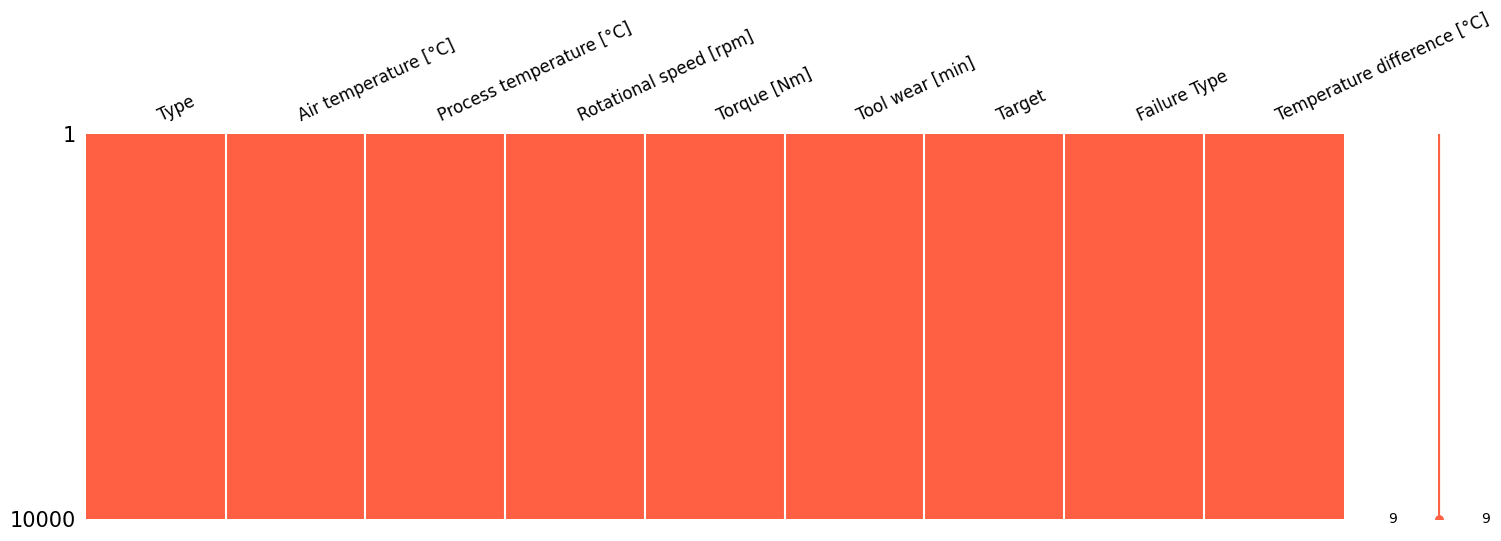

In [111]:
msno.matrix(df, figsize=(18,5), fontsize=12, color=(1, 0.38, 0.27));
plt.xticks(rotation=25);

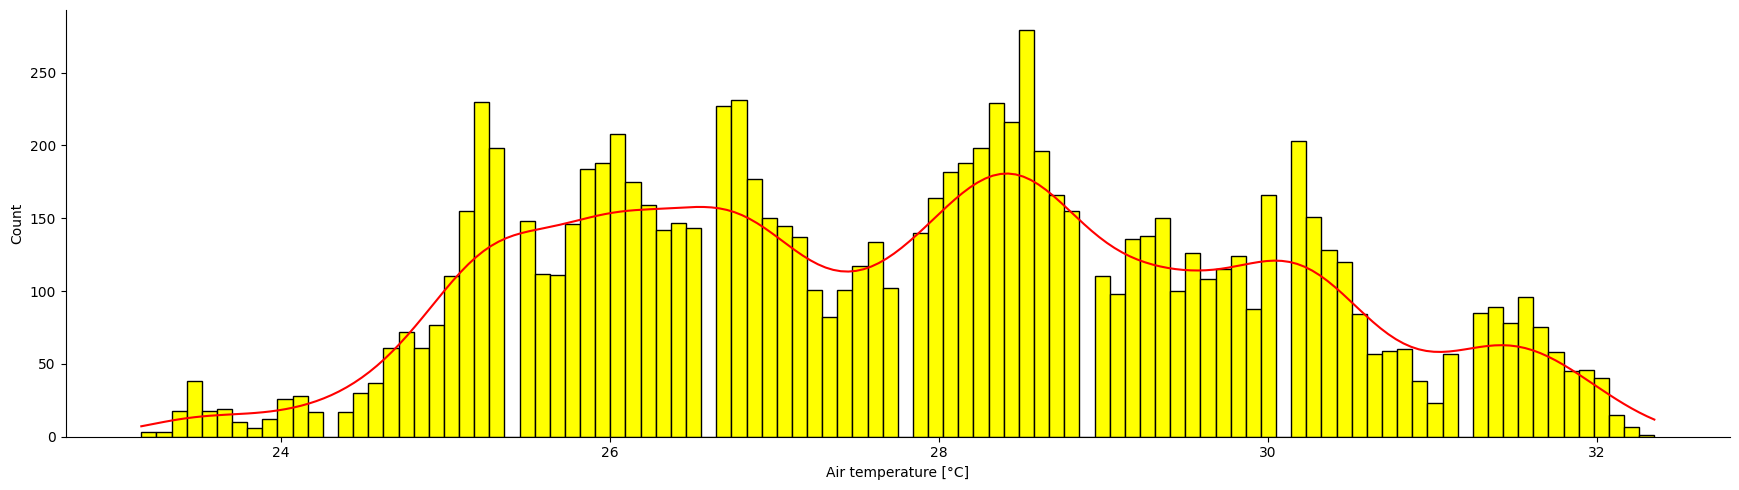

In [112]:
sns.displot(data=df, x="Air temperature [°C]", kde=True, bins = 100,color = "red", facecolor = "yellow",height = 5, aspect = 3.5);

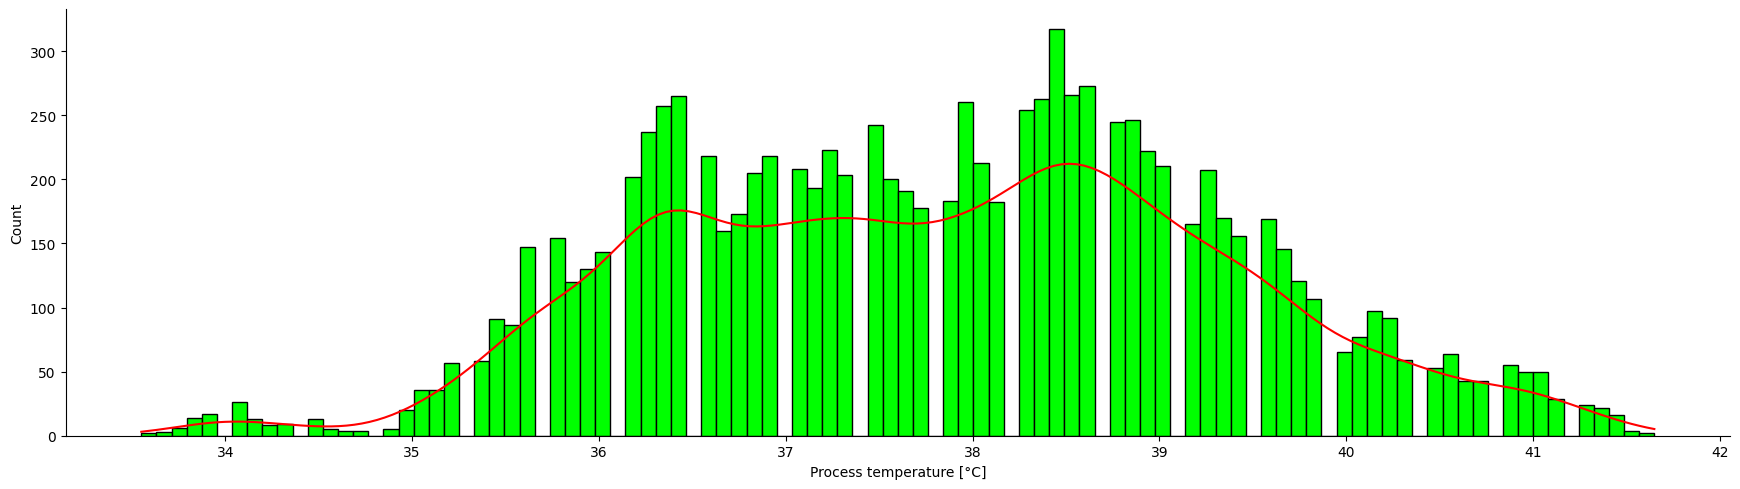

In [113]:
sns.displot(data=df, x="Process temperature [°C]", kde=True, bins = 100,color = "red", facecolor = "lime",height = 5, aspect = 3.5);

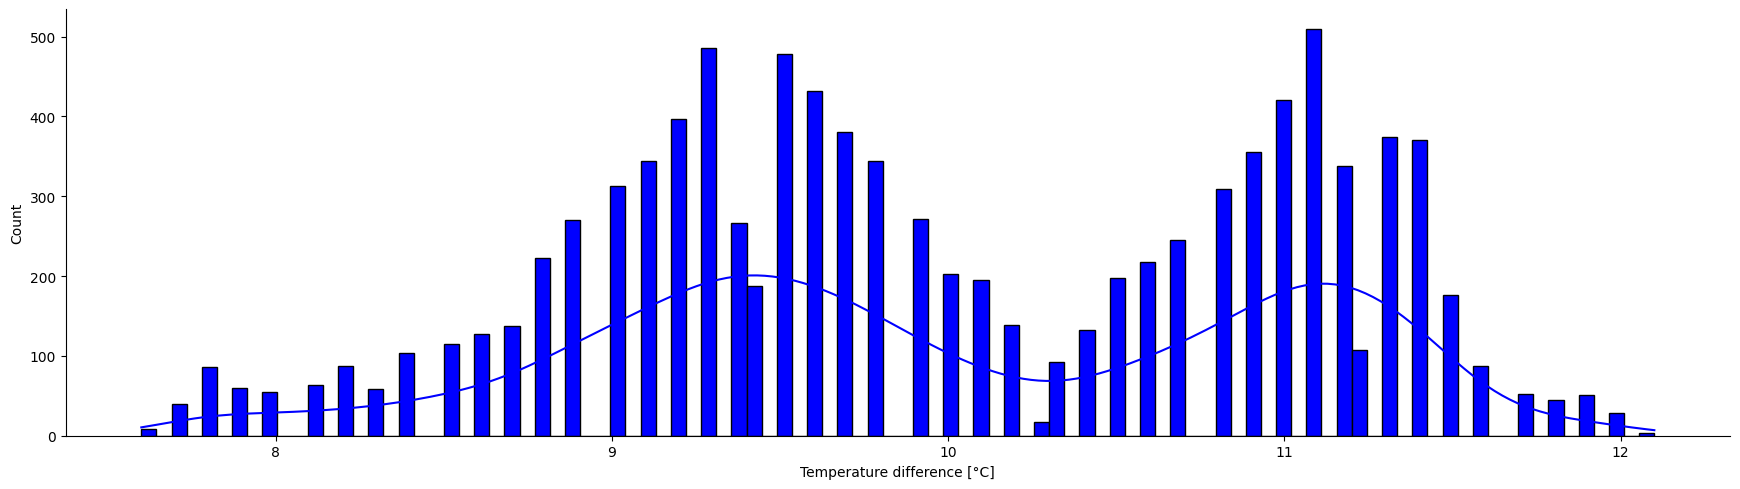

In [114]:
sns.displot(data=df, x="Temperature difference [°C]", kde=True, bins = 100,color = "blue", facecolor = "blue",height = 5, aspect = 3.5);

In [115]:
for col in df[['Type','Target','Failure Type']]:
    print(df[col].value_counts()) 
    print("****"*8)

L    6000
M    2997
H    1003
Name: Type, dtype: int64
********************************
0    9661
1     339
Name: Target, dtype: int64
********************************
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
********************************


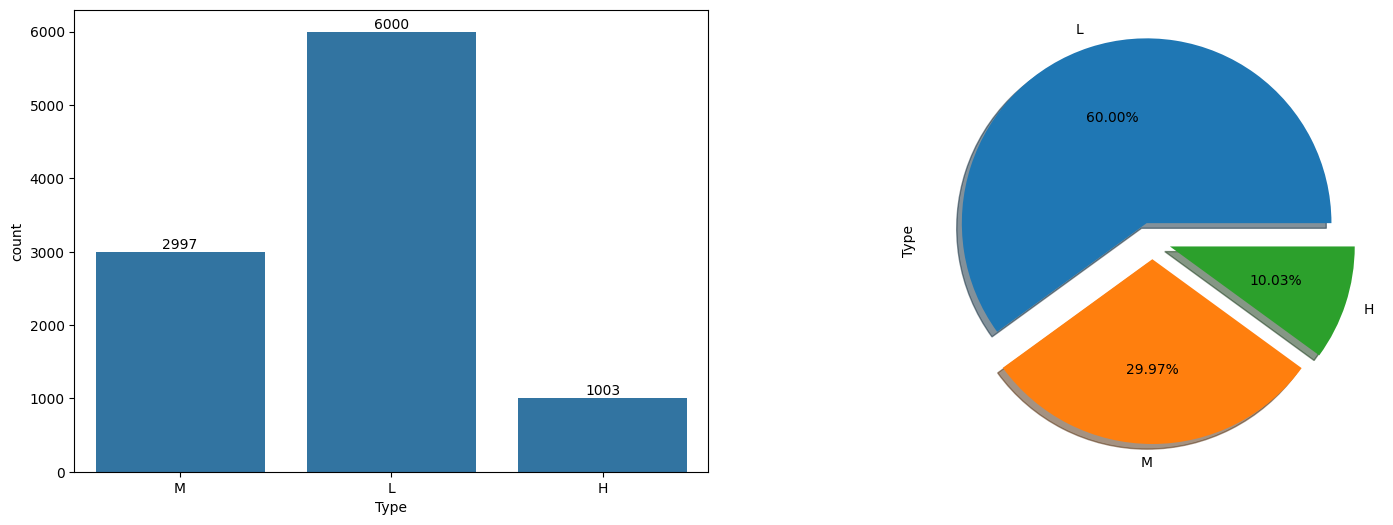

In [116]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Type', data=df)
ax.bar_label(ax.containers[0])
ax =plt.subplot(1,2,2)
ax=df['Type'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.2f%%', shadow=True);

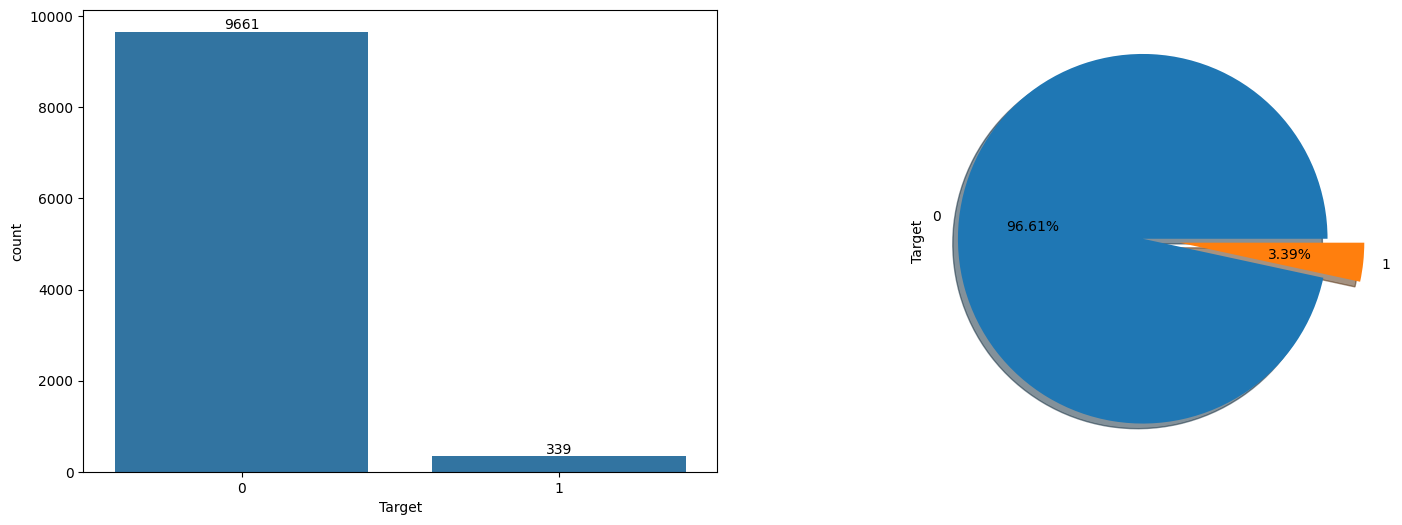

In [117]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Target', data=df)
ax.bar_label(ax.containers[0])
ax =plt.subplot(1,2,2)
ax=df['Target'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);

In [118]:
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5


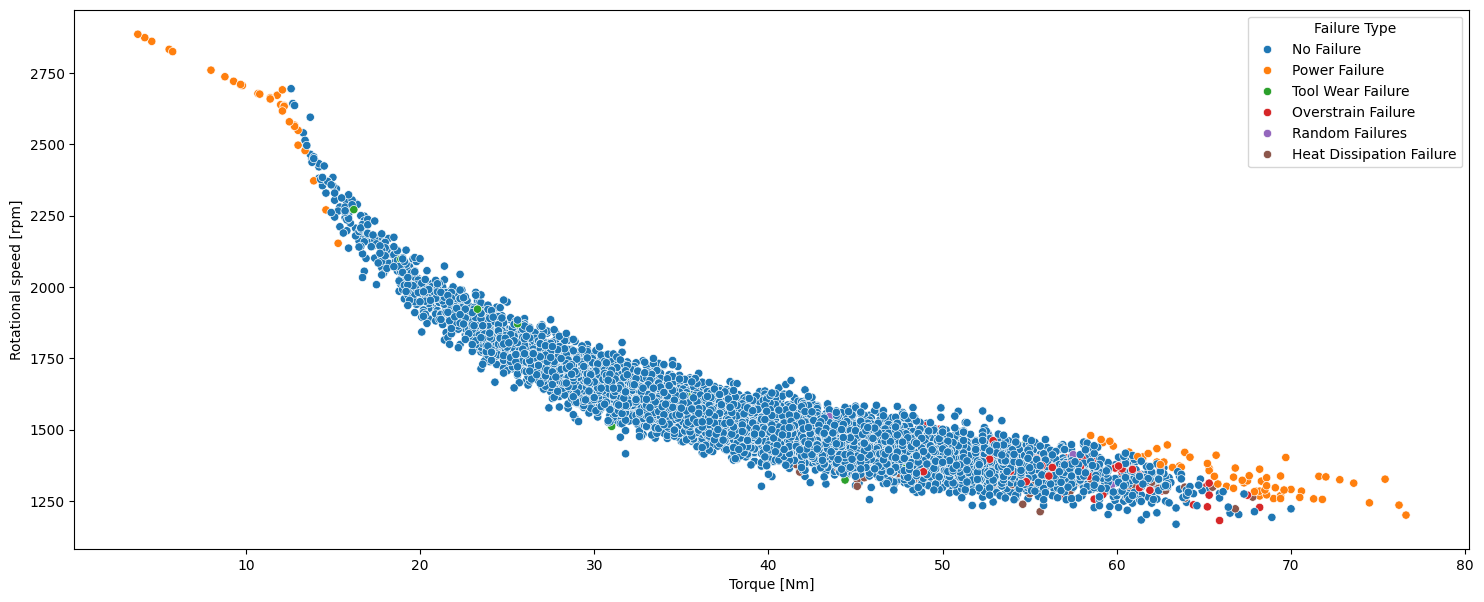

In [119]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",palette="tab10");

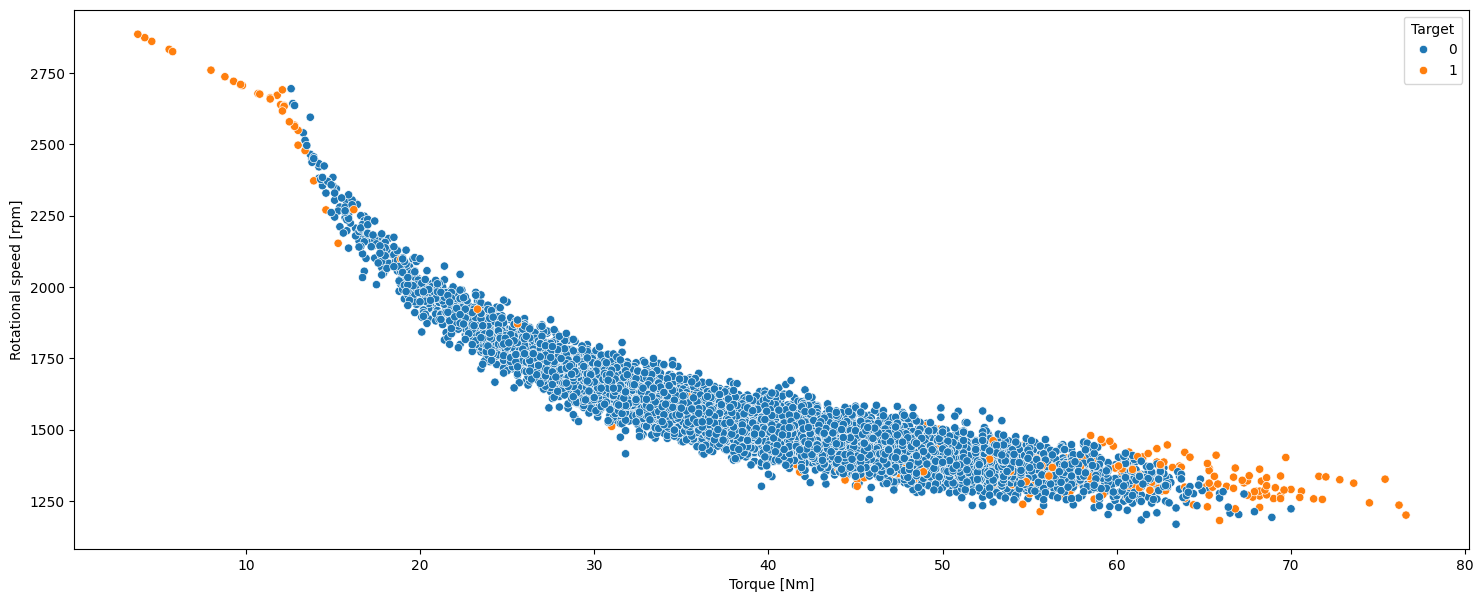

In [120]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Target",palette="tab10");

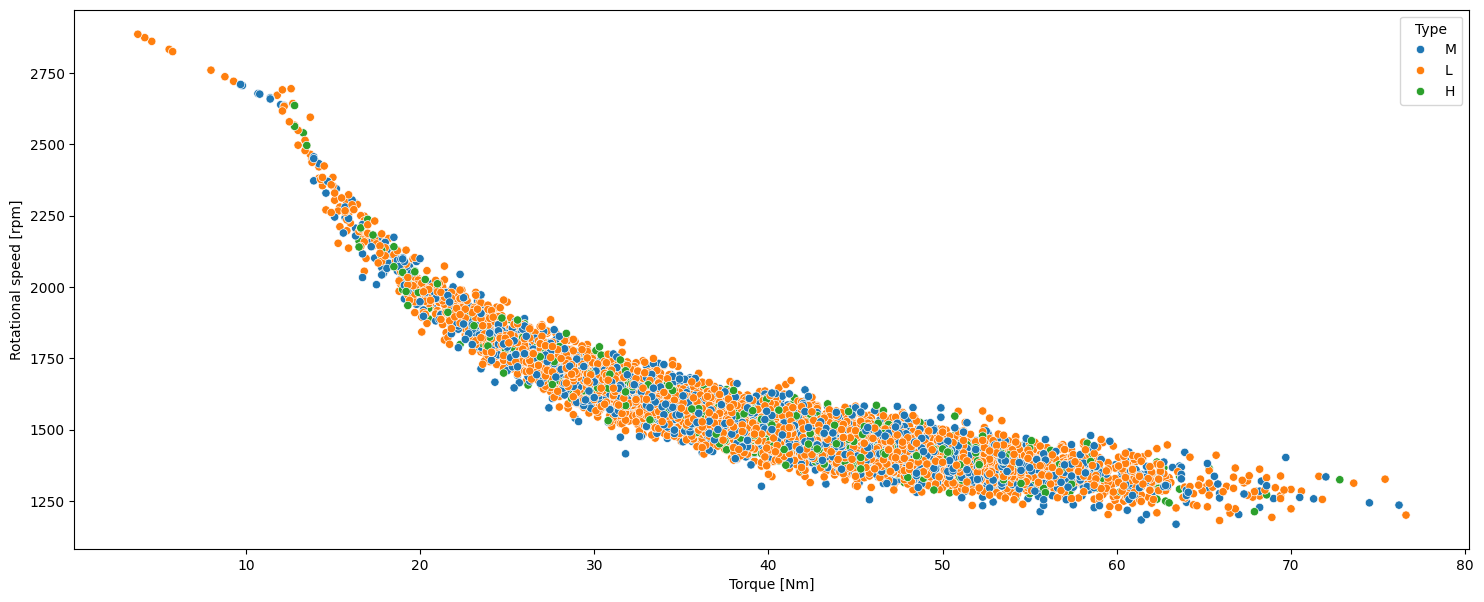

In [121]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Type",palette="tab10");

In [122]:
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5


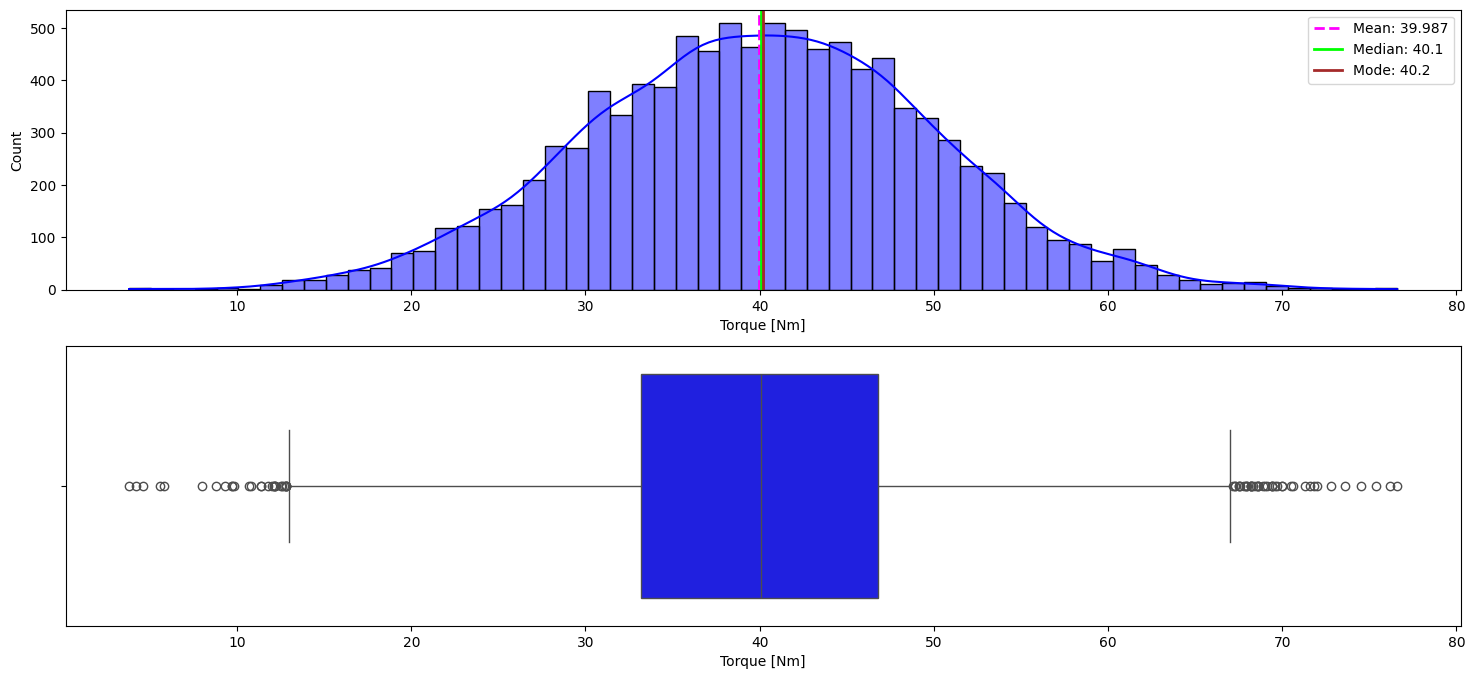

In [123]:
import statistics

def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='blue')

    ax[0].axvline(x = df[feature].mean(), color = 'Magenta', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'lime', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()
    
    sns.boxplot(x = df[feature], ax = ax[1],color='blue')
    
    plt.show()

plot_hist('Torque [Nm]')

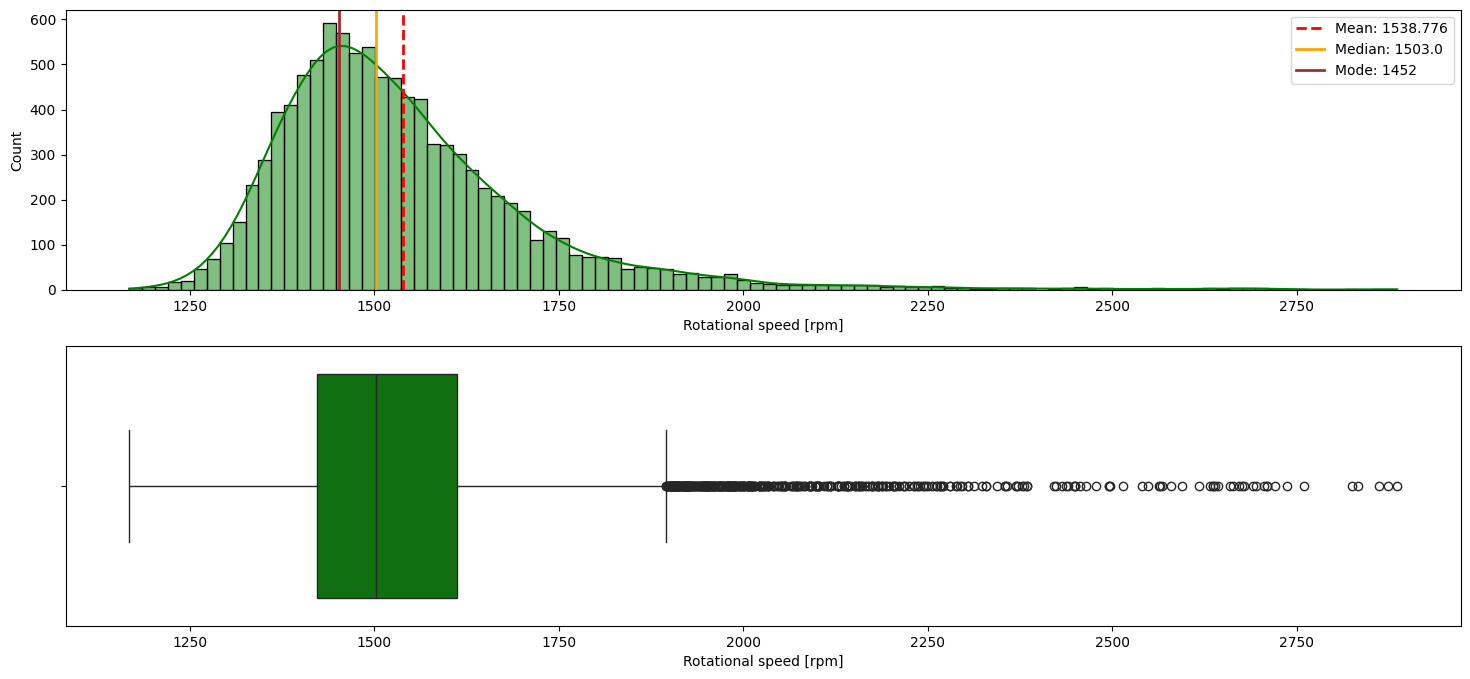

In [124]:
def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='green')

    ax[0].axvline(x = df[feature].mean(), color = 'red', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'orange', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()
    
    sns.boxplot(x = df[feature], ax = ax[1],color='green')
    
    plt.show()

plot_hist('Rotational speed [rpm]')

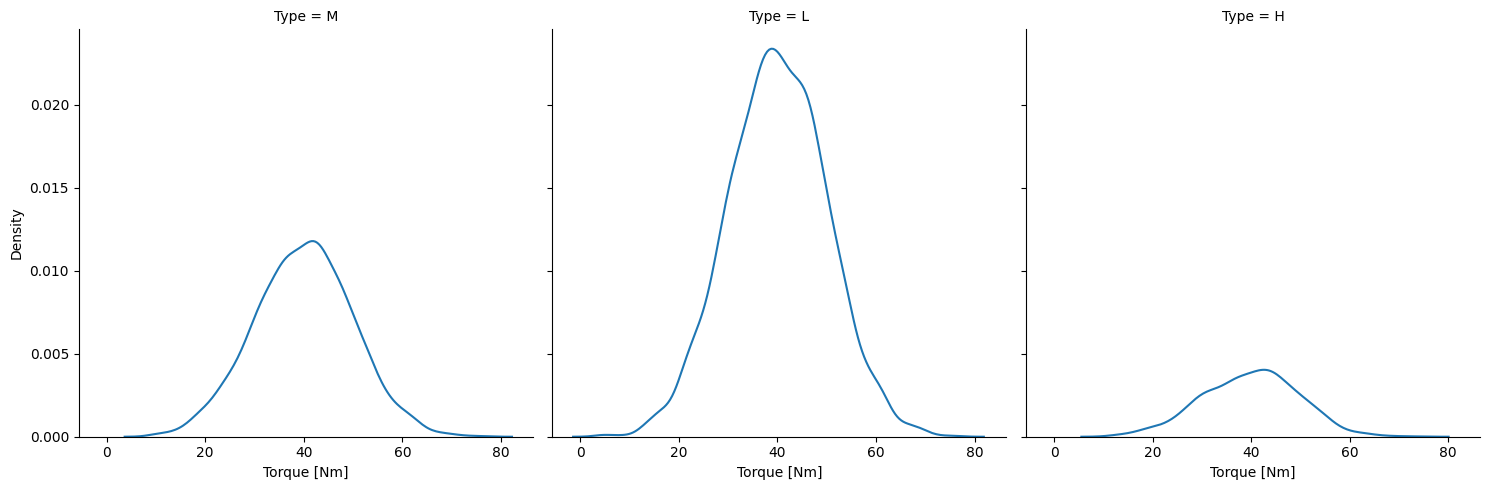

In [125]:
sns.displot(data=df, x="Torque [Nm]", col="Type", kind="kde");

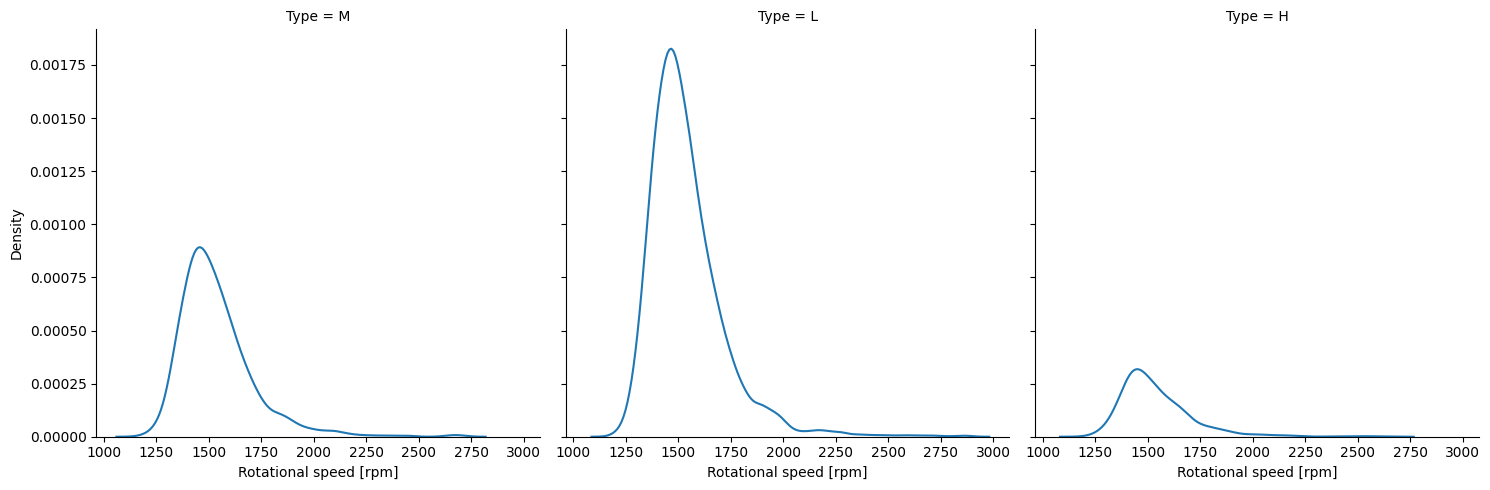

In [126]:
sns.displot(data=df, x="Rotational speed [rpm]", col="Type", kind="kde");

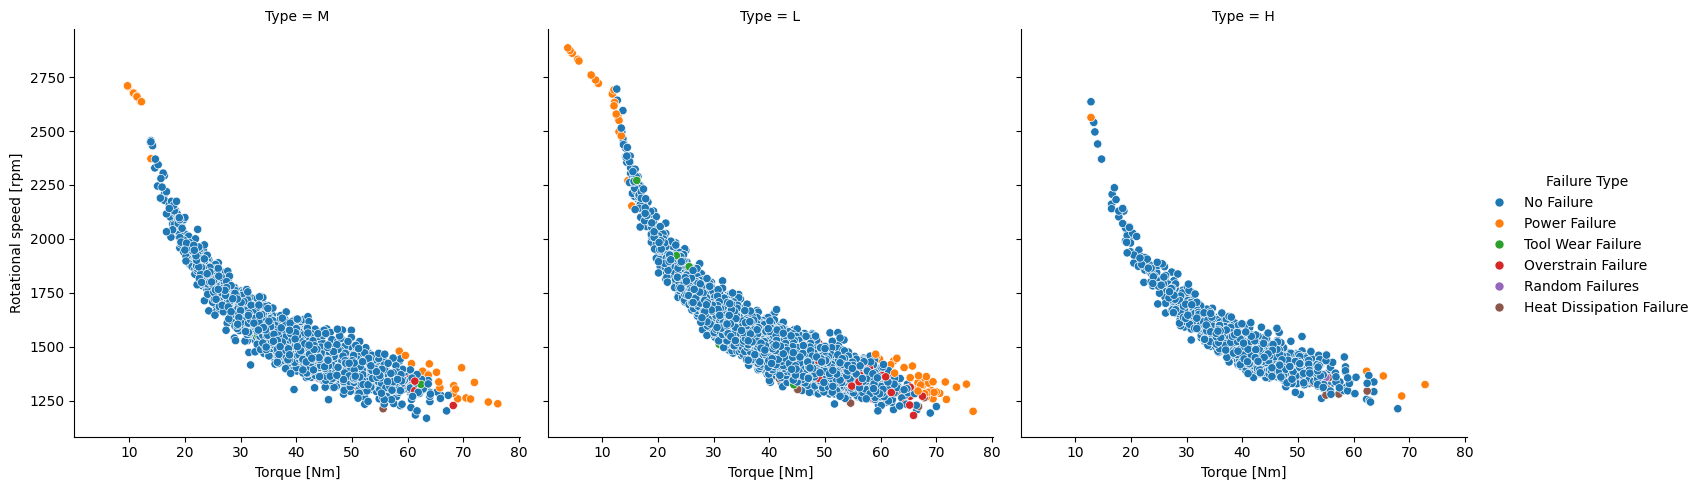

In [127]:
sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",col="Type",palette='tab10');

# Feature Selection

In [128]:
encoder = ce.OrdinalEncoder(cols=['Type','Failure Type'])
df = encoder.fit_transform(df)
df.head(2)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,1,25.95,36.45,1551,42.8,0,0,1,10.5
1,2,26.05,36.55,1408,46.3,3,0,1,10.5


In [129]:
scaler = LabelEncoder()
df['Failure Type'] = scaler.fit_transform(df['Failure Type'])

In [130]:
X = df.drop(columns="Failure Type" , axis=1)
y = df["Failure Type"]

In [131]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

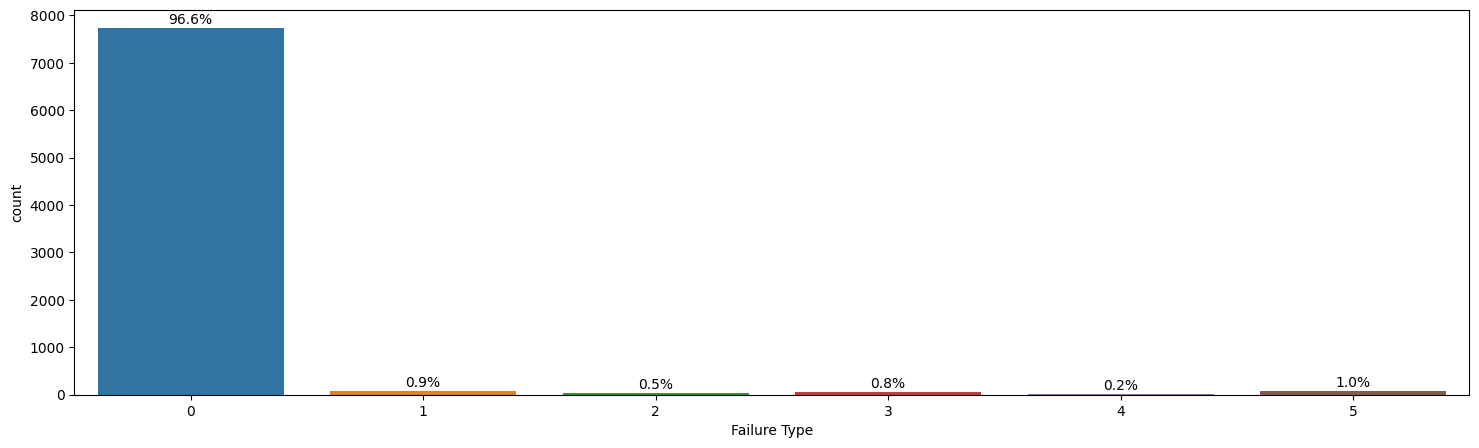

In [132]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_train, palette = 'tab10')
t= len(y_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

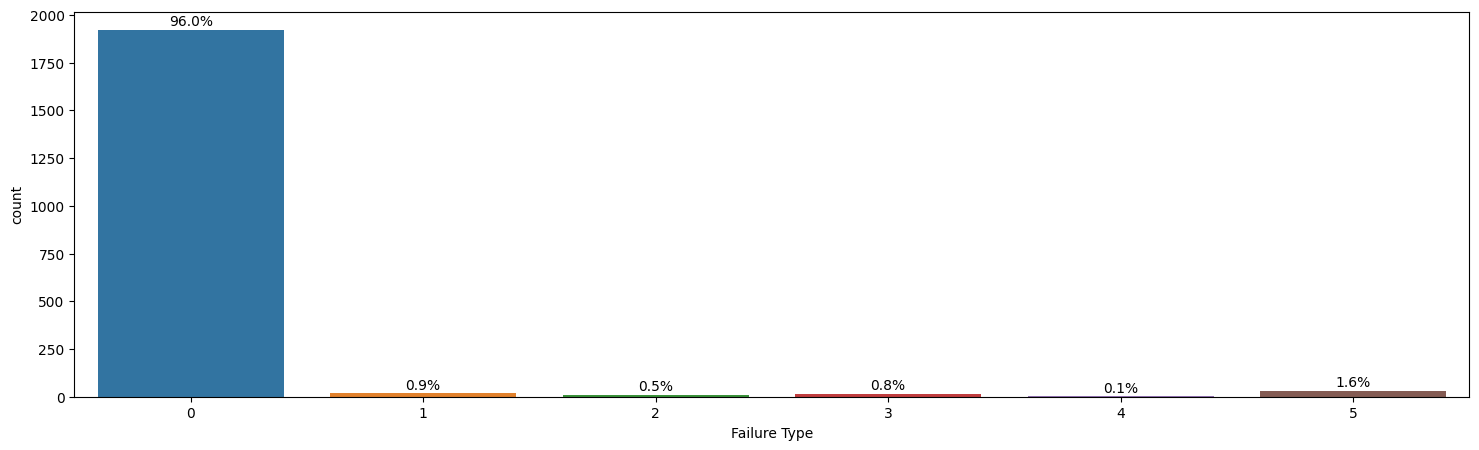

In [133]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_test, palette = 'tab10')
t= len(y_test)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

# Logistic Regression

Training Accuracy    : 96.74 %
Model Accuracy Score : 96.25 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1921
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         9
           3       0.67      0.38      0.48        16
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        32

    accuracy                           0.96      2000
   macro avg       0.27      0.23      0.24      2000
weighted avg       0.93      0.96      0.95      2000

--------------------------------------------------------


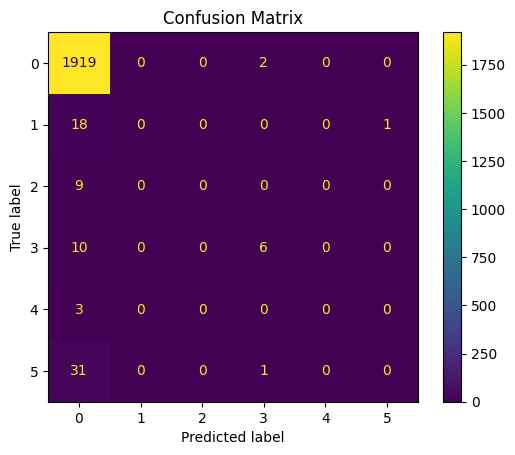

In [134]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

log_train = round(logreg.score(X_train, y_train) * 100, 2)
log_accuracy = round(accuracy_score(y_pred_lr, y_test) * 100, 2)

print("Training Accuracy    :",log_train ,"%")
print("Model Accuracy Score :",log_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_lr))
print("\033[1m--------------------------------------------------------\033[0m")

cm = confusion_matrix(y_test, y_pred_lr, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

plt.title('Confusion Matrix');

# Decision Tree Classifier

Training Accuracy    : 100.0 %
Model Accuracy Score : 99.4 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       0.81      0.89      0.85        19
           2       0.90      1.00      0.95         9
           3       0.92      0.75      0.83        16
           4       0.00      0.00      0.00         3
           5       0.97      0.97      0.97        32

    accuracy                           0.99      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.99      0.99      0.99      2000

--------------------------------------------------------


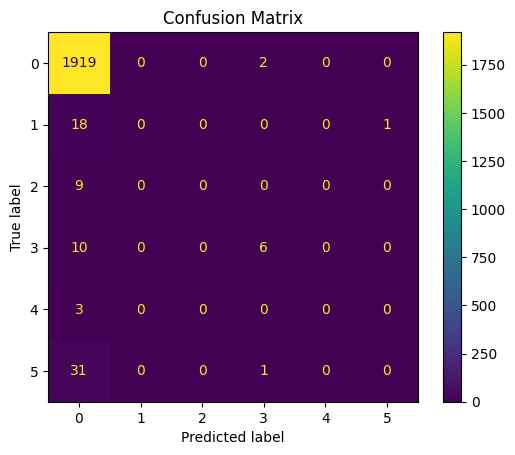

In [135]:
decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

decision_train = round(decision.score(X_train, y_train) * 100, 2)
decision_accuracy = round(accuracy_score(y_pred_dec, y_test) * 100, 2)

print("Training Accuracy    :",decision_train ,"%")
print("Model Accuracy Score :",decision_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_dec))
print("\033[1m--------------------------------------------------------\033[0m")

cm = confusion_matrix(y_test, y_pred_lr, labels=decision.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision.classes_)
disp.plot()

plt.title('Confusion Matrix');

# Random Forest Classifier

Training Accuracy    : 100.0 %
Model Accuracy Score : 99.65 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       0.90      0.95      0.92        19
           2       1.00      0.89      0.94         9
           3       0.94      0.94      0.94        16
           4       0.00      0.00      0.00         3
           5       0.97      0.97      0.97        32

    accuracy                           1.00      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       1.00      1.00      1.00      2000

--------------------------------------------------------


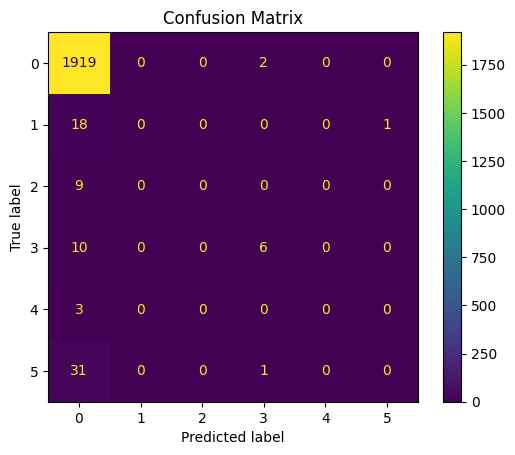

In [136]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)

print("Training Accuracy    :",random_forest_train ,"%")
print("Model Accuracy Score :",random_forest_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_rf))
print("\033[1m--------------------------------------------------------\033[0m")

cm = confusion_matrix(y_test, y_pred_lr, labels=random_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot()

plt.title('Confusion Matrix');

# Support Vector Machines (SVM)

Training Accuracy    : 96.64 %
Model Accuracy Score : 96.05 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1921
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        32

    accuracy                           0.96      2000
   macro avg       0.16      0.17      0.16      2000
weighted avg       0.92      0.96      0.94      2000

--------------------------------------------------------


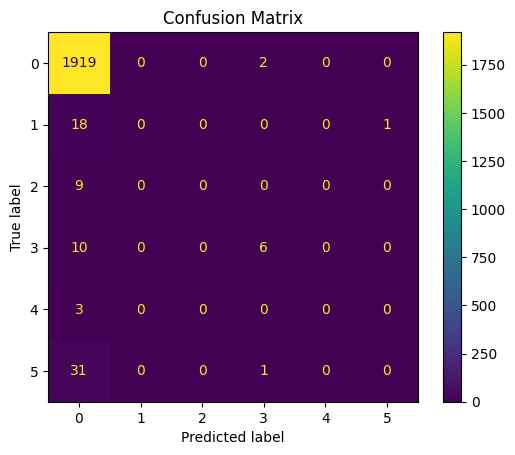

In [137]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_train = round(svc.score(X_train, y_train) * 100, 2)
svc_accuracy = round(accuracy_score(y_pred_svc, y_test) * 100, 2)

print("Training Accuracy    :",svc_train ,"%")
print("Model Accuracy Score :",svc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_svc))
print("\033[1m--------------------------------------------------------\033[0m")

cm = confusion_matrix(y_test, y_pred_lr, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

plt.title('Confusion Matrix');

# Model Comparison

In [138]:
models = pd.DataFrame({
    'Model': [
        'Support Vector Machines', 'Logistic Regression', 'Random Forest',
        'Decision Tree'
    ],
    
    'Training Accuracy':
    [log_train, svc_train, decision_train, random_forest_train],
    
    'Model Accuracy Score': [
        log_accuracy, svc_accuracy, decision_accuracy, random_forest_accuracy
    ]
})

In [139]:
models.sort_values(by='Model Accuracy Score', ascending=False).style.background_gradient(
        cmap='coolwarm').hide_index().set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

Model,Training Accuracy,Model Accuracy Score
Decision Tree,100.000000,99.650000
Random Forest,100.000000,99.400000
Support Vector Machines,96.740000,96.250000
Logistic Regression,96.640000,96.050000


# Model Prediction

In [140]:
prediction = decision.predict(X_test)
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction})
print(prediction)

[0 0 0 ... 0 0 0]


In [142]:
cross_checking.sample(10).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Actual,Predicted
1399,0,0
7864,0,0
2941,2,2
7538,0,0
2789,0,0
2142,0,0
1069,0,0
5098,0,0
790,0,0
2970,0,0
